# 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
#import keras as ks
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
#df = pd.DataFrame(boston.data, columns=boston.feature_names)
#df['target'] = boston.target

In [3]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Property Tax rate in the area|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. Regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

### Adding more readable column names

In [6]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [7]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Poor_People,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Poor_People,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [9]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Poor_People', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

In [10]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Poor_People,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Creating a corrolation matrix to see if there is any relationship betweek the variables.

In [11]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Poor_People,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


In [23]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Poor_People    -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

The average number of Rooms per House (0.7) and the % of People of Lower Status (-0.74) are the mostly strongly corrolated with the Median Value of houses

Also, worth noting the high corrolation between NOX and industrialisation (0.76) , Tax and Access to Highways (0.91)

### Corrolation and Sensitivity to different variables

1. Benefit of less NOX drops when DIS and RAD are removed. This is because the advantages of greater accessability cancel out the disadvantages of less clean air. 
2. The affect of higher NOX levels can easily be attributed to a higher proportion of lower status households. 
3. In general there is a high degree of heteroscedasticity. As X increases there is a larger variance in Y. 

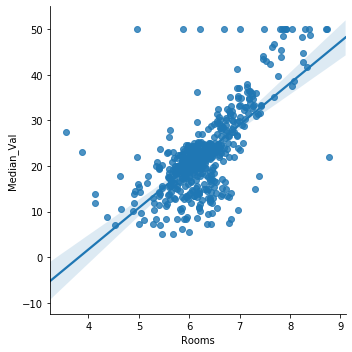

In [12]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

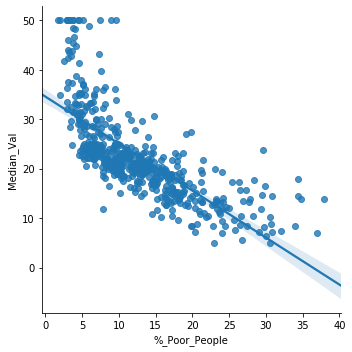

In [13]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

Looking at 2 next most closely corrolated attributes: Crime rate and Pupil teacher ratio shows there is a far less obvious relationship.

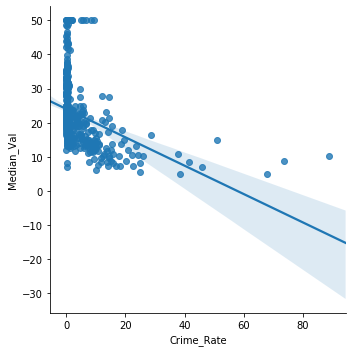

In [16]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="Crime_Rate", y="Median_Val", data=df)

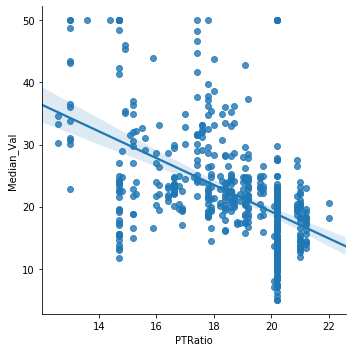

In [18]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

# 3. Inferential Statistics

# 4. Predictions


# 5. References

1. Why Multicollinearity is bad https://en.wikipedia.org/wiki/Multicollinearity (why we exclude Tax, Highway_access, Dis_to_jobs, and %Pre_1940)
2. Good example of the project with other features removed https://olegleyz.github.io/boston_housing.html
3. Another good project http://www.neural.cz/dataset-exploration-boston-house-pricing.html
